# MLP

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import ast
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import pandas as pd
import numpy as np
import ast

In [6]:
data = pd.read_csv("./embeddings_data.csv")

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
permutation = np.random.permutation(len(data))
data = data.iloc[permutation]

In [8]:
X = np.vstack([np.array(ast.literal_eval(vec), dtype=float) for vec in data["embedding_cls"]])
y = data["class"].values

In [9]:
test_size = int(y.shape[0] * 0.15)
val_size = int(y.shape[0] * 0.15)
train_size = int(y.shape[0] * 0.7)

In [13]:
X_train = torch.tensor(X[:train_size], dtype=torch.float32)
y_train = torch.tensor(y[:train_size], dtype=torch.float32)

X_val = torch.tensor(X[train_size:train_size + val_size], dtype=torch.float32)
y_val = torch.tensor(y[train_size:train_size + val_size], dtype=torch.float32)

X_test = torch.tensor(X[train_size + val_size:], dtype=torch.float32)
y_test = torch.tensor(y[train_size + val_size:], dtype=torch.float32)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

(torch.Size([33383, 768]),
 torch.Size([33383]),
 torch.Size([7153, 768]),
 torch.Size([7153]),
 torch.Size([7154, 768]),
 torch.Size([7154]))

In [48]:
class MLP(nn.Module):
    def __init__(self, input_dim, n_hidden_layers=1, n_neurons=128):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        current_neurons = n_neurons
        last_dim = input_dim
        for _ in range(n_hidden_layers):
            self.layers.append(nn.Linear(last_dim, current_neurons))
            self.layers.append(nn.ReLU())
            last_dim = current_neurons
            current_neurons = max(8, current_neurons // 2)
        self.output_layer = nn.Linear(last_dim, 1)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return torch.sigmoid(self.output_layer(x))

In [64]:
param_grid = {
    "n_hidden_layers": [1, 2, 4],
    "n_neurons": [32, 64, 128]
}

best_params = None
best_score = 0
best_model = None

def train_and_eval(model, train_loader, val_loader, epochs=20):
    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb).squeeze()
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = (model(xb).squeeze() >= 0.5).float()
            correct += (preds == yb).sum().item()
            total += yb.size(0)

    return correct / total

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)

for layers in param_grid["n_hidden_layers"]:
    for neurons in param_grid["n_neurons"]:
        print(f"\n Evaluando: capas={layers}, neuronas={neurons}")
        model = MLP(input_dim=X_train.shape[1], n_hidden_layers=layers, n_neurons=neurons)
        acc = train_and_eval(model, train_loader, val_loader)
        print(f"val_accuracy: {acc:.4f}")
        if acc > best_score:
            best_score = acc
            best_params = (layers, neurons)
            best_model = model

print(f"\n Mejor combinación: capas={best_params[0]}, neuronas={best_params[1]}")


 Evaluando: capas=1, neuronas=32
val_accuracy: 0.8494

 Evaluando: capas=1, neuronas=64
val_accuracy: 0.8574

 Evaluando: capas=1, neuronas=128
val_accuracy: 0.8429

 Evaluando: capas=2, neuronas=32
val_accuracy: 0.8571

 Evaluando: capas=2, neuronas=64
val_accuracy: 0.8554

 Evaluando: capas=2, neuronas=128
val_accuracy: 0.8546

 Evaluando: capas=4, neuronas=32
val_accuracy: 0.8594

 Evaluando: capas=4, neuronas=64
val_accuracy: 0.8554

 Evaluando: capas=4, neuronas=128
val_accuracy: 0.8567

 Mejor combinación: capas=4, neuronas=32


In [65]:
final_model = MLP(input_dim=X.shape[1], n_hidden_layers=best_params[0], n_neurons=best_params[1]).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(final_model.parameters(), lr=0.001)

X_train_gpu = X_train.to(device)
y_train_gpu = y_train.to(device)
X_val_gpu = X_val.to(device)
y_val_gpu = y_val.to(device)

train_loader = DataLoader(TensorDataset(X_train_gpu, y_train_gpu), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_gpu, y_val_gpu), batch_size=32)

epochs = 100

train_acc_history = []
val_acc_history = []
train_loss_history = []
val_loss_history = []

for epoch in range(epochs):
    final_model.train()
    running_train_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = final_model(xb).squeeze()
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * xb.size(0)

    avg_train_loss = running_train_loss / len(train_loader.dataset)

    final_model.eval()
    with torch.no_grad():
        train_preds = (final_model(X_train_gpu).squeeze() >= 0.5).float()
        train_acc = (train_preds == y_train_gpu).float().mean().item()

        val_preds = final_model(X_val_gpu).squeeze()
        val_loss = criterion(val_preds, y_val_gpu).item()
        val_acc = ((val_preds >= 0.5).float() == y_val_gpu).float().mean().item()

    train_loss_history.append(avg_train_loss)
    val_loss_history.append(val_loss)
    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f} - "
          f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1/100 - Train Loss: 0.3786, Val Loss: 0.3469 - Train Acc: 0.8555, Val Acc: 0.8429
Epoch 2/100 - Train Loss: 0.3332, Val Loss: 0.3305 - Train Acc: 0.8657, Val Acc: 0.8563
Epoch 3/100 - Train Loss: 0.3289, Val Loss: 0.3273 - Train Acc: 0.8698, Val Acc: 0.8612
Epoch 4/100 - Train Loss: 0.3188, Val Loss: 0.3366 - Train Acc: 0.8628, Val Acc: 0.8568
Epoch 5/100 - Train Loss: 0.3143, Val Loss: 0.3543 - Train Acc: 0.8518, Val Acc: 0.8479
Epoch 6/100 - Train Loss: 0.3118, Val Loss: 0.3308 - Train Acc: 0.8707, Val Acc: 0.8575
Epoch 7/100 - Train Loss: 0.3095, Val Loss: 0.3299 - Train Acc: 0.8712, Val Acc: 0.8563
Epoch 8/100 - Train Loss: 0.3051, Val Loss: 0.3342 - Train Acc: 0.8654, Val Acc: 0.8546
Epoch 9/100 - Train Loss: 0.3023, Val Loss: 0.3289 - Train Acc: 0.8716, Val Acc: 0.8587
Epoch 10/100 - Train Loss: 0.3012, Val Loss: 0.3308 - Train Acc: 0.8707, Val Acc: 0.8566
Epoch 11/100 - Train Loss: 0.3005, Val Loss: 0.3365 - Train Acc: 0.8688, Val Acc: 0.8580
Epoch 12/100 - Train Loss: 0.2

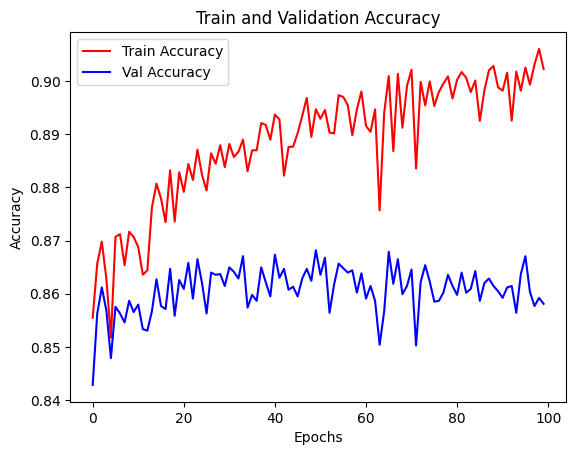

In [66]:
plt.plot(train_acc_history, label='Train Accuracy', color='red')
plt.plot(val_acc_history, label='Val Accuracy', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Validation Accuracy')
plt.show()

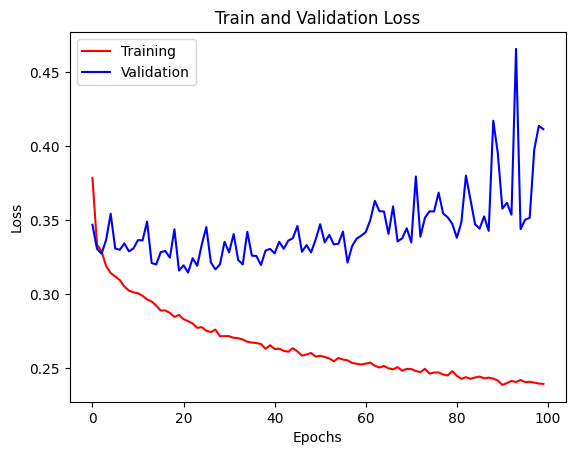

In [67]:
plt.plot(train_loss_history, label='Training', color='red')
plt.plot(val_loss_history, label='Validation', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

              precision    recall  f1-score   support

           0       0.80      0.93      0.86      3486
           1       0.92      0.78      0.85      3668

    accuracy                           0.85      7154
   macro avg       0.86      0.86      0.85      7154
weighted avg       0.86      0.85      0.85      7154



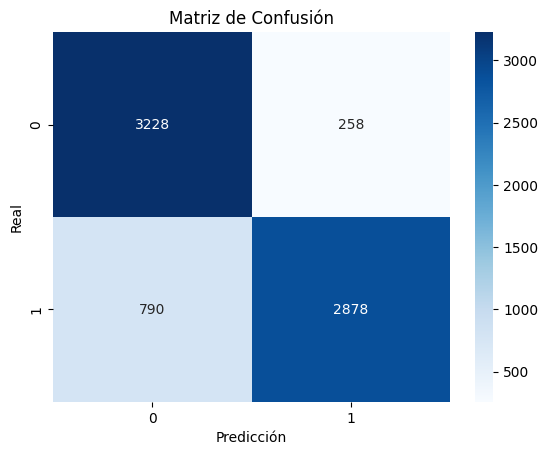

In [68]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Move test data to the same device as the model
X_test_gpu = X_test.to(device)
y_test_gpu = y_test.to(device)

# Set model to evaluation mode
best_model.eval()

# Make predictions on test set
with torch.no_grad():
    y_pred_probs = best_model(X_test_gpu).squeeze()
    y_pred = (y_pred_probs >= 0.5).int().cpu().numpy()  # move back to CPU for sklearn

# Convert y_test to NumPy array (ensure it's on CPU)
y_test_np = y_test_gpu.cpu().numpy().astype(int)

# Print classification report
print(classification_report(y_test_np, y_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_np, y_pred)

# Plot confusion matrix heatmap
sns.heatmap(conf_matrix, xticklabels=["0", "1"], yticklabels=["0", "1"], annot=True, cmap='Blues', fmt='g')
plt.ylabel("Real")
plt.xlabel("Predicción")
plt.title("Matriz de Confusión")
plt.show()
